In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pprint
import glob
import datetime
import random
import re
import warnings
from sklearn.impute import KNNImputer

warnings.filterwarnings('ignore')


*The MOD_YEAR column may have cars that are outside the specific data range only because some car models made in year "X" are made to be called year "X + 1" models

# Loading Files:

#### Loading Accident Data:

In [ ]:
# FARS data files folder
# Data path can be replaced with wherever the user stored their data 
base_direct = "~/data/FARS_Data/"

# Empty dictionary that stores every year's df
acc_data = {}

# Add data from CSV files from 1975 to 2022
for year in range(1975, 2023):
    
    # Create the year's file path
    file_path = base_direct + f"ACCIDENT_{year}.csv"
    
    # ISO-8859-1 encoding is the type for these CSV files:
    acc_data[f'{year}'] = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False)



In [3]:
len(acc_data)

48

In [4]:
acc_data['2021'].shape

(39508, 80)

In [5]:
acc_data['2022'].shape

(39221, 80)

In [6]:
acc_data['1975'].head()

,STATE,COUNTY,MONTH,DAY,YEAR,HOUR,MINUTE,VE_FORMS,PERSONS,VEHICLES,...,SCH_BUS,CF1,CF2,CF3,FATALS,DAY_WEEK,DRUNK_DR,ST_CASE,CITY,RAIL
0,1,95,1,4,75,22,24,3,3,NaN,...,NaN,0,0,0,1,7,0,10001,400,*******
1,1,95,1,2,75,4,30,1,2,NaN,...,NaN,0,0,0,1,5,0,10002,110,*******
2,1,35,1,1,75,4,0,1,1,NaN,...,NaN,0,0,0,1,4,0,10003,0,*******
3,1,77,1,2,75,14,50,1,3,NaN,...,NaN,0,0,0,1,5,0,10004,0,*******
4,1,97,1,5,75,20,0,1,1,NaN,...,NaN,0,0,0,1,1,0,10005,2100,*******


In [7]:
type(acc_data['1975'].head())

pandas.core.frame.DataFrame

#### Loading Vehicle Data:

Only loading ST_CASE & DEATHS plus selected variables bc the recent vehicle data files have many columns (2021 has 182 columns) & many of them are overlaps from what's in ACCIDENTS and are not as relevant like many HAZ columns and different types of VIN numbers.

The final list of columns subsetted from vehicle data are:

ST_CASE (primary key)

DEATHS (response variable)

explanatory variables:

'ST_CASE', 'HIT_RUN', 'MOD_YEAR', 'DR_DRINK', 'DEATHS'


In [ ]:
base_direct = "~/data/FARS_Data/"

vehc_data = {}

columns_to_include = ['ST_CASE', 'HIT_RUN', 'MOD_YEAR', 'DR_DRINK', 'DEATHS']

for year in range(1975, 2023):
    file_path = os.path.join(base_direct, f"VEHICLE_{year}.csv")
    
    try:
        df = pd.read_csv(file_path, encoding='ISO-8859-1', low_memory=False, usecols=columns_to_include)
        vehc_data[str(year)] = df
        
    except FileNotFoundError:
        print(f"File not found for year {year}.")
    except pd.errors.EmptyDataError:
        print(f"No data found for year {year}.")


In [9]:
len(vehc_data)

48

In [10]:
vehc_data['1975'].shape

(55534, 5)

In [11]:
vehc_data['1982'].shape

(56455, 5)

In [12]:
vehc_data['1991'].shape

(54795, 5)

In [13]:
vehc_data['2001'].shape

(57918, 5)

In [14]:
vehc_data['2008'].shape

(50660, 5)

In [15]:
vehc_data['2015'].shape

(49478, 5)

In [16]:
vehc_data['2021'].shape

(61332, 5)

In [17]:
vehc_data['2022'].shape

(60501, 5)

In [18]:
vehc_data['1975'].head()

,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK,ST_CASE
0,0,73,0,0,10001
1,0,69,0,0,10001
2,0,69,1,0,10001
3,0,71,1,0,10002
4,0,72,1,0,10003


In [19]:
vehc_data['1982'].head()

,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK,ST_CASE
0,0,72,2,0,10001
1,0,69,1,0,10002
2,0,70,1,1,10003
3,0,80,2,1,10004
4,2,66,0,1,10005


# The EDA Steps Are:

1. Filtering unnecessary columns
2. Counting NAs in each column & imputing them
3. Rewording and simplifying column values
4. Summary statistics of quantitative columns

#### Filtering Unnecessary Columns:

Need to exclude columns that assign numbers to diff categories. For instance, numbers are assigned to each state, but this numerical column should be excluded since the states have no hierarchy to them.

In [20]:
acc_data['2021'].columns

Index(['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL',
       'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT', 'COUNTY', 'COUNTYNAME',
       'CITY', 'CITYNAME', 'MONTH', 'MONTHNAME', 'DAY', 'DAYNAME', 'DAY_WEEK',
       'DAY_WEEKNAME', 'YEAR', 'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME',
       'TWAY_ID', 'TWAY_ID2', 'ROUTE', 'ROUTENAME', 'RUR_URB', 'RUR_URBNAME',
       'FUNC_SYS', 'FUNC_SYSNAME', 'RD_OWNER', 'RD_OWNERNAME', 'NHS',
       'NHSNAME', 'SP_JUR', 'SP_JURNAME', 'MILEPT', 'MILEPTNAME', 'LATITUDE',
       'LATITUDENAME', 'LONGITUD', 'LONGITUDNAME', 'HARM_EV', 'HARM_EVNAME',
       'MAN_COLL', 'MAN_COLLNAME', 'RELJCT1', 'RELJCT1NAME', 'RELJCT2',
       'RELJCT2NAME', 'TYP_INT', 'TYP_INTNAME', 'REL_ROAD', 'REL_ROADNAME',
       'WRK_ZONE', 'WRK_ZONENAME', 'LGT_COND', 'LGT_CONDNAME', 'WEATHER',
       'WEATHERNAME', 'SCH_BUS', 'SCH_BUSNAME', 'RAIL', 'RAILNAME', 'NOT_HOUR',
       'NOT_HOURNAME', 'NOT_MIN', 'NOT_MINNAME', 'ARR_HOUR', 'ARR_HOURNAME',
       'ARR_M

In [21]:
acc_data['2022'].columns

Index(['STATE', 'STATENAME', 'ST_CASE', 'PEDS', 'PERNOTMVIT', 'VE_TOTAL',
       'VE_FORMS', 'PVH_INVL', 'PERSONS', 'PERMVIT', 'COUNTY', 'COUNTYNAME',
       'CITY', 'CITYNAME', 'MONTH', 'MONTHNAME', 'DAY', 'DAYNAME', 'DAY_WEEK',
       'DAY_WEEKNAME', 'YEAR', 'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME',
       'TWAY_ID', 'TWAY_ID2', 'ROUTE', 'ROUTENAME', 'RUR_URB', 'RUR_URBNAME',
       'FUNC_SYS', 'FUNC_SYSNAME', 'RD_OWNER', 'RD_OWNERNAME', 'NHS',
       'NHSNAME', 'SP_JUR', 'SP_JURNAME', 'MILEPT', 'MILEPTNAME', 'LATITUDE',
       'LATITUDENAME', 'LONGITUD', 'LONGITUDNAME', 'HARM_EV', 'HARM_EVNAME',
       'MAN_COLL', 'MAN_COLLNAME', 'RELJCT1', 'RELJCT1NAME', 'RELJCT2',
       'RELJCT2NAME', 'TYP_INT', 'TYP_INTNAME', 'REL_ROAD', 'REL_ROADNAME',
       'WRK_ZONE', 'WRK_ZONENAME', 'LGT_COND', 'LGT_CONDNAME', 'WEATHER',
       'WEATHERNAME', 'SCH_BUS', 'SCH_BUSNAME', 'RAIL', 'RAILNAME', 'NOT_HOUR',
       'NOT_HOURNAME', 'NOT_MIN', 'NOT_MINNAME', 'ARR_HOUR', 'ARR_HOURNAME',
       'ARR_M

In [22]:
acc_columns = set(acc_data['1975'].columns)


In [23]:
# Subsetting relevant 29 columns from acc_data:

acc_relv_cols = ['STATENAME', 'ST_CASE', 'PEDS', 'VE_TOTAL', 'PERSONS', 'COUNTYNAME', 'CITYNAME', 
                 'MONTHNAME', 'DAYNAME', 'DAY_WEEKNAME', 'HOUR', 'TWAY_ID', 'ROUTENAME', 'RUR_URBNAME', 
                 'FUNC_SYSNAME', 'RD_OWNERNAME', 'MILEPT', 'LATITUDE', 'LONGITUD', 'HARM_EVNAME', 
                 'MAN_COLLNAME', 'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONENAME', 'LGT_CONDNAME', 
                 'WEATHERNAME', 'SCH_BUS', 'FATALS']

# Checking if each relevant column is present within each dataframe since older year
# files don't have many columns present in newer year files

# The variable "cmn_cols" only has relevant columns that are part of the dataframe 
# and stores them in a dictionary called: subset_acc_data

subset_acc_data = {}

for key, df in acc_data.items():
    cmn_cols = [col for col in acc_relv_cols if col in df.columns]
    subset_acc_data[key] = df[cmn_cols]



In [24]:
len(subset_acc_data)

48

In [25]:
type(subset_acc_data)

dict

In [26]:
# Each year df shapes since newer years have more columns than older years:
for key, val in subset_acc_data.items():
    print(val.shape)

(39161, 5)
(39747, 5)
(42211, 5)
(44433, 5)
(45223, 5)
(45284, 5)
(44000, 5)
(39092, 7)
(37976, 7)
(39631, 7)
(39196, 7)
(41090, 7)
(41438, 7)
(42130, 7)
(40741, 7)
(39836, 7)
(36937, 8)
(34942, 8)
(35780, 8)
(36254, 8)
(37241, 8)
(37494, 8)
(37324, 8)
(37107, 8)
(37140, 10)
(37526, 10)
(37862, 8)
(38491, 8)
(38477, 8)
(38444, 8)
(39252, 9)
(38648, 9)
(37435, 9)
(34172, 11)
(30862, 11)
(30296, 11)
(29867, 11)
(31006, 11)
(30202, 11)
(30056, 11)
(32538, 26)
(34748, 28)
(34560, 28)
(33919, 28)
(33487, 28)
(35935, 28)
(39508, 28)
(39221, 28)


It seems that not all of the 29 relevant columns are in the earlier years of accident data. To address this, different models will be trained for different time periods & compared accordingly to assess changes in the dependent variable based on different "time periods" such as:

Time Period 1: 1975 - 1981 all have 5 columns

Time Period 2: 1982 - 1990 all have 7 columns

Time Period 3: 1991 - 2000 all have 8 columns (1999 & 2000 have 10 columns but will be reduced to 8)

Time Period 4: 2001 - 2007 (2001 to 2004 has 8 columns & 2005 to 2007 has 9, but these will be reduced to 8 colums for consistency in the time period)

Time Period 5: 2008 - 2014 all have 11 columns

Time Period 6: 2015 - 2022 all have 28 columns except 2015 that has 26, but all of its values will be marked as missing or imputed so that the other columns' values are preserved

#### Joining Accidents & Vehicles Data:

In [28]:
# Inner join the dfs based on the common index ST_CASE
merged_data = {}
for year in range(1975, 2023):
    if str(year) in subset_acc_data and str(year) in vehc_data:
        merged_data[str(year)] = pd.merge(subset_acc_data[str(year)], vehc_data[str(year)], 
                                          left_index=True, right_on='ST_CASE', how='inner', 
                                          suffixes=('_acc', '_vehc'))
    else:
        merged_data[str(year)] = pd.DataFrame()


In [29]:
# Dropping extra duplicate columns of ST_CASE:
for year, df in merged_data.items():
    
    # Get the list of duplicte columns similar to ST_CASE
    columns_to_drop = [col for col in df.columns if col.startswith('ST_CASE') and col != 'ST_CASE']
    
    # Drop the duplicates (ST_CASEx and ST_CASEy)
    df.drop(columns=columns_to_drop, inplace=True)


In [30]:
# Print the shape of each year's df & group into 6 sections based on similar numbers of columns:
for year, df in merged_data.items():
    print(f"Year {year}: {df.shape}")


Year 1975: (1282, 9)
Year 1976: (1348, 9)
Year 1977: (2635, 9)
Year 1978: (2908, 9)
Year 1979: (2669, 9)
Year 1980: (2469, 9)
Year 1981: (2459, 9)
Year 1982: (1202, 11)
Year 1983: (1372, 11)
Year 1984: (1394, 11)
Year 1985: (1320, 11)
Year 1986: (2859, 11)
Year 1987: (2698, 11)
Year 1988: (2701, 11)
Year 1989: (2553, 11)
Year 1990: (1622, 11)
Year 1991: (1587, 12)
Year 1992: (1492, 12)
Year 1993: (1486, 12)
Year 1994: (1551, 12)
Year 1995: (1638, 12)
Year 1996: (1660, 12)
Year 1997: (1734, 12)
Year 1998: (1551, 12)
Year 1999: (1624, 14)
Year 2000: (1493, 14)
Year 2001: (1494, 12)
Year 2002: (1477, 12)
Year 2003: (1515, 12)
Year 2004: (1688, 12)
Year 2005: (1657, 13)
Year 2006: (1695, 13)
Year 2007: (1587, 13)
Year 2008: (1384, 15)
Year 2009: (1231, 15)
Year 2010: (1241, 15)
Year 2011: (1311, 15)
Year 2012: (1306, 15)
Year 2013: (1184, 15)
Year 2014: (1167, 15)
Year 2015: (1272, 30)
Year 2016: (1525, 32)
Year 2017: (1366, 32)
Year 2018: (1425, 32)
Year 2019: (1406, 32)
Year 2020: (1387,

In [31]:
merged_data['1978'].columns

Index(['ST_CASE', 'PERSONS', 'HOUR', 'SCH_BUS', 'FATALS', 'HIT_RUN',
       'MOD_YEAR', 'DEATHS', 'DR_DRINK'],
      dtype='object')

In [32]:
merged_data['1985'].columns

Index(['ST_CASE', 'PERSONS', 'HOUR', 'TWAY_ID', 'MILEPT', 'SCH_BUS', 'FATALS',
       'HIT_RUN', 'MOD_YEAR', 'DEATHS', 'DR_DRINK'],
      dtype='object')

In [33]:
merged_data['1993'].columns

Index(['ST_CASE', 'PEDS', 'PERSONS', 'HOUR', 'TWAY_ID', 'MILEPT', 'SCH_BUS',
       'FATALS', 'HIT_RUN', 'MOD_YEAR', 'DEATHS', 'DR_DRINK'],
      dtype='object')

In [34]:
merged_data['2001'].columns

Index(['ST_CASE', 'PEDS', 'PERSONS', 'HOUR', 'TWAY_ID', 'MILEPT', 'SCH_BUS',
       'FATALS', 'DEATHS', 'MOD_YEAR', 'DR_DRINK', 'HIT_RUN'],
      dtype='object')

In [35]:
merged_data['2014'].columns

Index(['ST_CASE', 'PEDS', 'VE_TOTAL', 'PERSONS', 'HOUR', 'TWAY_ID', 'MILEPT',
       'LATITUDE', 'LONGITUD', 'SCH_BUS', 'FATALS', 'HIT_RUN', 'MOD_YEAR',
       'DEATHS', 'DR_DRINK'],
      dtype='object')

In [36]:
merged_data['2022'].columns

Index(['ST_CASE', 'STATENAME', 'PEDS', 'VE_TOTAL', 'PERSONS', 'COUNTYNAME',
       'CITYNAME', 'MONTHNAME', 'DAYNAME', 'DAY_WEEKNAME', 'HOUR', 'TWAY_ID',
       'ROUTENAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME', 'MILEPT',
       'LATITUDE', 'LONGITUD', 'HARM_EVNAME', 'MAN_COLLNAME', 'TYP_INTNAME',
       'REL_ROADNAME', 'WRK_ZONENAME', 'LGT_CONDNAME', 'WEATHERNAME',
       'SCH_BUS', 'FATALS', 'HIT_RUN', 'MOD_YEAR', 'DEATHS', 'DR_DRINK'],
      dtype='object')

#### Time Period 1 - EDA & Data Cleaning to Prep for Modeling:

In [37]:
merged_data['1975'].head()

,ST_CASE,PERSONS,HOUR,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,4,20,NaN,1,0,73,0,0
1,10001,4,20,NaN,1,0,69,0,0
2,10001,4,20,NaN,1,0,69,1,0
3,10002,1,19,NaN,1,0,71,1,0
4,10003,2,22,NaN,2,0,72,1,0


In [38]:
merged_data_section_1 = {
    '1975': merged_data['1975'],
    '1976': merged_data['1976'],
    '1977': merged_data['1977'],
    '1978': merged_data['1978'],
    '1979': merged_data['1979'],
    '1980': merged_data['1980'],
    '1981': merged_data['1981']   
    
}


In [39]:
# Each year's df's number of NAs
na_counts_dict_sect_1 = {}

# Storing every column's NA counts in a dictionary
for yr, df in merged_data_section_1.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_1[yr] = na_counts

# Print year's columns' NA counts
for yr, na_counts in na_counts_dict_sect_1.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 1975:
ST_CASE        0
PERSONS        0
HOUR           0
SCH_BUS     1282
FATALS         0
HIT_RUN        0
MOD_YEAR       0
DEATHS         0
DR_DRINK       0
dtype: int64
Year 1976:
ST_CASE        0
PERSONS        0
HOUR           0
SCH_BUS     1348
FATALS         0
HIT_RUN        0
MOD_YEAR       0
DEATHS         0
DR_DRINK       0
dtype: int64
Year 1977:
ST_CASE     0
PERSONS     0
HOUR        0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1978:
ST_CASE     0
PERSONS     0
HOUR        0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1979:
ST_CASE     0
PERSONS     0
HOUR        0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1980:
ST_CASE     0
PERSONS     0
HOUR        0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1981:
ST_CASE     0
PERSONS     0
HOUR   

In [40]:
merged_data_section_1['1975']['SCH_BUS']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1277   NaN
1278   NaN
1279   NaN
1280   NaN
1281   NaN
Name: SCH_BUS, Length: 1282, dtype: float64

SCH_BUS values are only present for 1977 data onwards but is completely missing for 1975 and 1976. The NA values in 1975 and 1976 will be imputed to be 0, meaning a school bus was not involved in the fatalities.

In [41]:
merged_data['1975'].loc[:, 'SCH_BUS'] = merged_data['1975']['SCH_BUS'].fillna(0)
merged_data['1975'].head()

,ST_CASE,PERSONS,HOUR,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,4,20,0.0,1,0,73,0,0
1,10001,4,20,0.0,1,0,69,0,0
2,10001,4,20,0.0,1,0,69,1,0
3,10002,1,19,0.0,1,0,71,1,0
4,10003,2,22,0.0,2,0,72,1,0


In [42]:
merged_data['1976'].loc[:, 'SCH_BUS'] = merged_data['1976']['SCH_BUS'].fillna(0)
merged_data['1976'].head()

,ST_CASE,PERSONS,HOUR,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,2,14,0.0,1,0,70,0,0
1,10001,2,14,0.0,1,0,72,0,0
2,10002,3,16,0.0,1,0,75,0,0
3,10002,3,16,0.0,1,0,72,0,0
4,10003,2,13,0.0,2,0,75,0,0


#### Time Period 2 - EDA & Data Cleaning to Prep for Modeling:
Time Period 2: 1982 - 1990 all have 7 columns

In [43]:
merged_data['1982'].head()

,ST_CASE,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,2,19,130,78.0,0,1,0,72,2,0
1,10002,2,23,285S,99999.0,0,1,0,69,1,0
2,10003,1,12,285N,99999.0,0,1,0,70,1,1
3,10004,1,1,15,36.0,0,1,0,80,2,1
4,10005,2,15,285W,99999.0,0,1,2,66,0,1


In [44]:
merged_data_section_2 = {
    '1982': merged_data['1982'],
    '1983': merged_data['1983'],
    '1984': merged_data['1984'],
    '1985': merged_data['1985'],
    '1986': merged_data['1986'],
    '1987': merged_data['1987'],
    '1988': merged_data['1988'],
    '1989': merged_data['1989'],
    '1990': merged_data['1990']
    
}


In [45]:
na_counts_dict_sect_2 = {}

for yr, df in merged_data_section_2.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_2[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_2.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 1982:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1983:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1984:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1985:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1986:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1987:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
H

The column TWAY_ID represents the road name where the accident occurred It may stand for through-way ID. Number values can be assumed to be the route number. For the relatively few missing values in some of the years' dataframes, the best is to replace NA values with "Missing" so that NA values don't interfere with model building.

Missing values of milepoint will be replaced with the mean & it will remain quantitative.

In [46]:
for year, df in merged_data_section_2.items():
    
    merged_data_section_2[year]['TWAY_ID'].fillna('Missing', inplace=True)


In [47]:
# Recheck the number of NA values:

for yr, df in merged_data_section_2.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_2[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_2.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 1982:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1983:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1984:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1985:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1986:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1987:
ST_CASE     0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
H

In [48]:
merged_data['1990'].tail(30)

,ST_CASE,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
1592,20075,2,22,313,9,0,1,0,85,1,0
1593,20076,2,5,5,461,0,1,0,89,1,0
1594,20076,2,5,5,461,0,1,0,90,0,0
1595,20076,2,5,5,461,0,1,0,85,0,0
1596,20077,2,6,10,525,0,1,0,83,1,1
1597,20078,2,10,162,11,0,1,0,90,1,0
1598,20078,2,10,162,11,0,1,0,85,0,0
1599,20079,2,16,68,1368,0,1,0,81,2,0
1600,20079,2,16,68,1368,0,1,0,90,0,0
1601,20080,2,3,I494,661,0,1,0,78,1,0


#### Time Period 3 - EDA & Data Cleaning to Prep for Modeling:

Time Period 3: 1991 - 2000 all have 8 columns (1999 & 2000 have 10 columns but will be reduced to 8)

In [49]:
merged_data['1991'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,0,4,2,I75,3173,0,1,0,89,1,0
1,10002,0,1,8,307,87,0,1,0,76,0,0
2,10002,0,1,8,307,87,0,1,0,85,0,0
3,10002,0,1,8,307,87,0,1,0,89,1,0
4,10002,0,1,8,307,87,0,1,0,87,1,0


In [50]:
# Years 1991 to 2000
merged_data_section_3 = {
    '1991': merged_data['1991'],
    '1992': merged_data['1992'],
    '1993': merged_data['1993'],
    '1994': merged_data['1994'],
    '1995': merged_data['1995'],
    '1996': merged_data['1996'],
    '1997': merged_data['1997'],
    '1998': merged_data['1998'],
    '1999': merged_data['1999'],
    '2000': merged_data['2000'],
}

In [51]:
na_counts_dict_sect_3 = {}

for yr, df in merged_data_section_3.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_3[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_3.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 1991:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1992:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1993:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1994:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1995:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1996:
ST_CASE     0
PEDS        0
P

In [52]:
# Remove 2 columns in 1999 & 2000 that are not present in the rest of this 
# time period's dataframes:

merged_data_section_3['1999'] = merged_data_section_3['1999'].drop(columns=['LATITUDE', 
                                                                    'LONGITUD'])

merged_data_section_3['2000'] = merged_data_section_3['2000'].drop(columns=['LATITUDE', 
                                                                    'LONGITUD'])

In [53]:
merged_data_section_3['1999'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,3,14,US-129(SR247),190,0,1,1,1989,1,0
1,10002,1,4,19,N MADISON ST,13,0,1,0,1994,1,0
2,10002,1,4,19,N MADISON ST,13,0,1,1,1989,0,0
3,10003,0,2,12,SR-369,29,0,1,1,1982,0,0
4,10004,0,2,7,US-29(SR14),201,0,1,2,1974,0,0


In [54]:
merged_data_section_3['2000'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,5,14,US-341(SR27),87,0,1,0,1989,0,2
1,10002,0,4,15,SR-138,46,0,1,1,1984,1,0
2,10003,1,3,19,I-20(SR402),113,0,1,1,1989,0,0
3,10004,0,6,12,I-85(SR 403),77,0,1,1,1987,1,0
4,10005,1,3,20,SR-184,13,0,1,1,1988,0,0


The only values that are missing are for TWAY_ID & MILEPT.

In [55]:
# Imputing values for TWAY_ID & MILEPT:
for year, df in merged_data_section_3.items():
    
    merged_data_section_3[year]['TWAY_ID'].fillna('Missing', inplace=True)


In [56]:
# Recheck NA Values:

for yr, df in merged_data_section_3.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_3[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_3.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 1991:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1992:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1993:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1994:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1995:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 1996:
ST_CASE     0
PEDS        0
P

In [57]:
merged_data['2000'].tail(30)

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,LATITUDE,LONGITUD,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
1463,20072,0,4,22,239,0,88888888,888888888,0,1,1,1991,0,0
1464,20072,0,4,22,239,0,88888888,888888888,0,1,0,1996,0,0
1465,20073,0,2,1,US-71,99,88888888,888888888,0,1,1,1990,0,0
1466,20073,0,2,1,US-71,99,88888888,888888888,0,1,2,2000,0,0
1467,20074,0,2,4,I-44,21,88888888,888888888,0,2,0,1988,0,0
1468,20075,0,1,10,I-435,155,88888888,888888888,0,1,1,1998,0,0
1469,20076,0,1,11,132,0,88888888,888888888,0,1,1,1994,0,0
1470,20076,0,1,11,132,0,88888888,888888888,0,1,0,1976,0,0
1471,20077,0,5,17,US-54,124,88888888,888888888,0,1,1,2000,1,0
1472,20078,0,1,10,US-71,183,88888888,888888888,0,1,1,1990,0,0


#### Time Period 4 - EDA & Data Cleaning to Prep for Modeling:

Time Period 4: 2001 - 2007 (2001 to 2004 has 8 columns & 2005 to 2007 has 9, but these will be reduced to 8 colums for consistency in the time period)

In [58]:
merged_data['2001'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,2,21,I-75 (SR 401),124.0,0,1,1,1997,1,0
1,10002,0,4,10,I-75 (SR 401),12.0,0,1,1,1994,0,0
2,10003,0,2,14,US-25 (SR 23),106.0,0,1,1,1992,0,0
3,10004,0,2,1,237,30.0,0,1,1,1987,1,0
4,10004,0,2,1,237,30.0,0,1,0,1989,0,0


In [59]:
merged_data['2005'].head()

,ST_CASE,PEDS,VE_TOTAL,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,2,6,2,US-301,99999.0,0,1,0,2001,0,0
1,10001,0,2,6,2,US-301,99999.0,0,1,1,2001,1,0
2,10002,0,1,2,5,I-75,99999.0,0,2,1,1999,1,0
3,10003,1,1,2,23,SR-1OA,99999.0,0,1,1,1992,0,0
4,10004,1,1,2,15,US-441,99999.0,0,1,1,2003,0,0


In [60]:
merged_data_section_4 = {
    '2001': merged_data['2001'],
    '2002': merged_data['2002'],
    '2003': merged_data['2003'],
    '2004': merged_data['2004'],
    '2005': merged_data['2005'],
    '2006': merged_data['2006'],
    '2007': merged_data['2007']
}

In [61]:
# Remove the VE_TOTAL column in 2005, 2006 & 2007 that are not present in the rest 
# of this time period's dataframes:

for year in range(2005, 2008):

    merged_data_section_4[str(year)] = merged_data_section_4[str(year)].drop(columns=
                                                                     ['VE_TOTAL'])

In [62]:
merged_data_section_4['2007'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,3,11,I-10,99999.0,0,1,1,1992,0,0
1,10002,0,2,11,I-4,99999.0,0,1,0,1990,0,0
2,10002,0,2,11,I-4,99999.0,0,1,2,1993,0,0
3,10002,0,2,11,I-4,99999.0,0,1,0,2004,0,0
4,10003,0,2,11,I-75,99999.0,0,1,0,2006,0,1


In [63]:
na_counts_dict_sect_4 = {}

for yr, df in merged_data_section_4.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_4[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_4.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 2001:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
HIT_RUN     0
dtype: int64
Year 2002:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
HIT_RUN     0
dtype: int64
Year 2003:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
HIT_RUN     0
dtype: int64
Year 2004:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
HIT_RUN     0
dtype: int64
Year 2005:
ST_CASE     0
PEDS        0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
SCH_BUS     0
FATALS      0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
HIT_RUN     0
dtype: int64
Year 2006:
ST_CASE     0
PEDS        0
P

#### Time Period 5 - EDA & Data Cleaning to Prep for Modeling:
Time Period 5: 2008 - 2014 all have 11 columns

In [64]:
merged_data['2008'].head()

,ST_CASE,PEDS,VE_TOTAL,PERSONS,HOUR,TWAY_ID,MILEPT,LATITUDE,LONGITUD,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,1,1,18,SR-253,158.0,30.963258,-84.568056,0,1,0,2006,0,0
1,10002,0,2,5,17,SR-14 AL,105.0,33.604111,-84.538122,0,3,1,2003,0,0
2,10002,0,2,5,17,SR-14 AL,105.0,33.604111,-84.538122,0,3,0,2000,0,0
3,10003,0,2,3,13,SR-120,32.0,33.767589,-85.242619,0,1,1,2001,1,0
4,10004,0,1,1,1,SR-104,68.0,33.557275,-82.160483,0,1,1,1993,0,0


In [65]:
merged_data_section_5 = {
    '2008': merged_data['2008'],
    '2009': merged_data['2009'],
    '2010': merged_data['2010'],
    '2011': merged_data['2011'],
    '2012': merged_data['2012'],
    '2013': merged_data['2013'],
    '2014': merged_data['2014']
}

In [66]:
na_counts_dict_sect_5 = {}

for yr, df in merged_data_section_5.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_5[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_5.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 2008:
ST_CASE      0
PEDS         0
VE_TOTAL     0
PERSONS      0
HOUR         0
TWAY_ID      0
MILEPT       0
LATITUDE    33
LONGITUD    33
SCH_BUS      0
FATALS       0
DEATHS       0
MOD_YEAR     0
DR_DRINK     0
HIT_RUN      0
dtype: int64
Year 2009:
ST_CASE      0
PEDS         0
VE_TOTAL     0
PERSONS      0
HOUR         0
TWAY_ID      0
MILEPT       0
LATITUDE    10
LONGITUD    10
SCH_BUS      0
FATALS       0
HIT_RUN      0
DEATHS       0
MOD_YEAR     0
DR_DRINK     0
dtype: int64
Year 2010:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
LATITUDE    0
LONGITUD    0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 2011:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
LATITUDE    0
LONGITUD    0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 2012:
ST_CASE     0
PEDS     

In [67]:
merged_data['2009']

,ST_CASE,PEDS,VE_TOTAL,PERSONS,HOUR,TWAY_ID,MILEPT,LATITUDE,LONGITUD,SCH_BUS,FATALS,HIT_RUN,DEATHS,MOD_YEAR,DR_DRINK
0,10001,0,2,3,23,HUETTE,0.0,39.013264,-90.011350,0,3,0,1,2001,0
1,10001,0,2,3,23,HUETTE,0.0,39.013264,-90.011350,0,3,0,0,2002,0
2,10002,1,2,7,18,63RD STREET,0.0,41.780522,-87.596203,0,1,0,0,2002,0
3,10003,1,1,2,21,US-6,948.0,41.353667,-88.884267,0,1,0,2,2004,0
4,10003,1,1,2,21,US-6,948.0,41.353667,-88.884267,0,1,0,0,2002,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,20056,0,2,3,13,US-421,99999.0,34.384956,-78.030653,0,1,0,1,1993,1
1227,20057,1,1,2,16,RP-1710,99999.0,34.908950,-79.049636,0,1,0,1,1989,1
1228,20058,0,1,1,1,BAYNES ROAD,99999.0,36.302419,-79.820286,0,1,0,1,2006,0
1229,20058,0,1,1,1,BAYNES ROAD,99999.0,36.302419,-79.820286,0,1,0,0,2002,0


#### KNN Imputation for Latitude & Longitude:
Because mean imputation would not make sense for geographical locations.

Chose number of neighbors to be 176 because it's the square root of the number of observations in the 2009 dataframe: sqrt(30,862) ~ 176. 

This is a logical value to start for the number of neighbors to impute just like the default value for mtry tends to be the square root of the number of observations.

In [68]:
# KNNImputer object
imputer = KNNImputer(n_neighbors=176) 

for year in range(2008, 2010):

    # Applying the KNNImputer object to missing latitdude & longitude values
    imputed_data = imputer.fit_transform(merged_data_section_5[str(year)][['LATITUDE', 
                                                                       'LONGITUD']])

    # Filling in NAs with imputed values
    merged_data_section_5[str(year)].loc[:, ['LATITUDE', 'LONGITUD']] = imputed_data


In [69]:
# Recheck NA values:

for yr, df in merged_data_section_5.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_5[yr] = na_counts


for yr, na_counts in na_counts_dict_sect_5.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 2008:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
LATITUDE    0
LONGITUD    0
SCH_BUS     0
FATALS      0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
HIT_RUN     0
dtype: int64
Year 2009:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
LATITUDE    0
LONGITUD    0
SCH_BUS     0
FATALS      0
HIT_RUN     0
DEATHS      0
MOD_YEAR    0
DR_DRINK    0
dtype: int64
Year 2010:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
LATITUDE    0
LONGITUD    0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 2011:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS     0
HOUR        0
TWAY_ID     0
MILEPT      0
LATITUDE    0
LONGITUD    0
SCH_BUS     0
FATALS      0
HIT_RUN     0
MOD_YEAR    0
DEATHS      0
DR_DRINK    0
dtype: int64
Year 2012:
ST_CASE     0
PEDS        0
VE_TOTAL    0
PERSONS    

#### Time Period 6 - EDA & Data Cleaning to Prep for Modeling:
Time Period 6: 2015 - 2022 all have 29 columns except 2015 that has 27, but all of its values will be marked as missing or imputed so that the other columns' values are preserved

In [70]:
merged_data['2015'].head()

,ST_CASE,STATENAME,PEDS,VE_TOTAL,PERSONS,MONTHNAME,DAYNAME,DAY_WEEKNAME,HOUR,TWAY_ID,...,REL_ROADNAME,WRK_ZONENAME,LGT_CONDNAME,WEATHERNAME,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,Georgia,1,1,2,November,9,Monday,19,SR-115,...,On Roadway,NaN,Dark - Not Lighted,Rain,0,1,0,2003,1,1
1,10002,Georgia,0,1,1,November,10,Tuesday,23,CR-61 / LAMAR RD,...,On Roadside,NaN,Dark - Not Lighted,Clear,0,1,0,2006,1,0
2,10003,Georgia,1,2,5,November,10,Tuesday,21,I-75,...,On Roadside,NaN,Dark - Not Lighted,Cloudy,0,1,0,2008,1,1
3,10004,Georgia,0,2,6,November,11,Wednesday,15,I-20,...,On Roadway,NaN,Daylight,Clear,0,1,0,2005,1,1
4,10005,Georgia,1,1,1,November,11,Wednesday,19,SR-138 SP / NORTH AVE,...,On Roadway,NaN,Dark - Not Lighted,Clear,0,1,0,2006,1,0


In [71]:
merged_data_section_6 = {
    '2015': merged_data['2015'],
    '2016': merged_data['2016'],
    '2017': merged_data['2017'],
    '2018': merged_data['2018'],
    '2019': merged_data['2019'],
    '2020': merged_data['2020'],
    '2021': merged_data['2021'],
    '2022': merged_data['2022']
}

No missing values found, except for 2 columns in the 2015 dataset, for which values will be filled in as missing:

In [72]:
columns_2015 = set(merged_data_section_6['2015'].columns)
columns_2016 = set(merged_data_section_6['2016'].columns)

columns_only_in_2016 = columns_2016 - columns_2015

print("Columns in 2016 but not in 2015:", columns_only_in_2016)


Columns in 2016 but not in 2015: {'CITYNAME', 'COUNTYNAME'}


Filling in missing columns in 2015 with 'Missing' so that these column values in years 2016 to 2022 are preserved for analyzing this time period:

In [73]:
merged_data_section_6['2015'].loc[:, 'COUNTYNAME'] = 'NOT AVAILABLE'
merged_data_section_6['2015'].loc[:, 'CITYNAME'] = 'NOT AVAILABLE'

In [74]:
merged_data_section_6['2015'].head()

,ST_CASE,STATENAME,PEDS,VE_TOTAL,PERSONS,MONTHNAME,DAYNAME,DAY_WEEKNAME,HOUR,TWAY_ID,...,LGT_CONDNAME,WEATHERNAME,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK,COUNTYNAME,CITYNAME
0,10001,Georgia,1,1,2,November,9,Monday,19,SR-115,...,Dark - Not Lighted,Rain,0,1,0,2003,1,1,NOT AVAILABLE,NOT AVAILABLE
1,10002,Georgia,0,1,1,November,10,Tuesday,23,CR-61 / LAMAR RD,...,Dark - Not Lighted,Clear,0,1,0,2006,1,0,NOT AVAILABLE,NOT AVAILABLE
2,10003,Georgia,1,2,5,November,10,Tuesday,21,I-75,...,Dark - Not Lighted,Cloudy,0,1,0,2008,1,1,NOT AVAILABLE,NOT AVAILABLE
3,10004,Georgia,0,2,6,November,11,Wednesday,15,I-20,...,Daylight,Clear,0,1,0,2005,1,1,NOT AVAILABLE,NOT AVAILABLE
4,10005,Georgia,1,1,1,November,11,Wednesday,19,SR-138 SP / NORTH AVE,...,Dark - Not Lighted,Clear,0,1,0,2006,1,0,NOT AVAILABLE,NOT AVAILABLE


In [75]:
na_counts_dict_sect_6 = {}

for yr, df in merged_data_section_6.items():
    na_counts = df.isna().sum()
    na_counts_dict_sect_6[yr] = na_counts

for yr, na_counts in na_counts_dict_sect_6.items():
    print(f"Year {yr}:")
    print(na_counts)

Year 2015:
ST_CASE            0
STATENAME          0
PEDS               0
VE_TOTAL           0
PERSONS            0
MONTHNAME          0
DAYNAME            0
DAY_WEEKNAME       0
HOUR               0
TWAY_ID            0
ROUTENAME          0
RUR_URBNAME        0
FUNC_SYSNAME       0
RD_OWNERNAME       0
MILEPT             0
LATITUDE           0
LONGITUD           0
HARM_EVNAME        0
MAN_COLLNAME       0
TYP_INTNAME        0
REL_ROADNAME       0
WRK_ZONENAME    1242
LGT_CONDNAME       0
WEATHERNAME        0
SCH_BUS            0
FATALS             0
HIT_RUN            0
MOD_YEAR           0
DEATHS             0
DR_DRINK           0
COUNTYNAME         0
CITYNAME           0
dtype: int64
Year 2016:
ST_CASE            0
STATENAME          0
PEDS               0
VE_TOTAL           0
PERSONS            0
COUNTYNAME         0
CITYNAME           0
MONTHNAME          0
DAYNAME            0
DAY_WEEKNAME       0
HOUR               0
TWAY_ID            0
ROUTENAME          0
RUR_URBNAME        0

All years of "accident" dataframes only have relevant columns & have no missing values. However, values within columns or column names themselves may need to be adjusted for easier understandability and ease of modeling. 

#### Time Period 1 - Renaming Column Values:

In [76]:
merged_data_section_1['1978'].head()

,ST_CASE,PERSONS,HOUR,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,2,12,0,1,0,78,0,0
1,10002,2,12,0,1,0,72,2,0
2,10003,2,15,1,1,0,77,1,0
3,10004,2,15,0,1,0,75,1,0
4,10005,3,15,0,1,0,68,1,1


In [77]:
pd.unique(merged_data_section_1['1978']['PERSONS'])

array([ 2,  3,  1,  7,  5,  4,  8,  6,  9, 10, 16, 13])

Potential issue with the value "99" for HOUR. It could mean it's a missing value:

In [78]:
pd.unique(merged_data_section_1['1978']['HOUR'])

array([12, 15, 20, 17,  1, 21,  2,  6, 11, 13,  3,  4, 19, 22,  7, 18, 16,
       14, 23, 10,  9,  0,  5,  8, 99, 24])

In [79]:
pd.unique(merged_data_section_1['1978']['SCH_BUS'])

array([0, 1])

In [80]:
# Imputing values for unreasonable values:
for year, df in merged_data_section_1.items():
    
    # Replace values where year = 99 with NaN since 99 means missing for 
    # time period 1 1975-1982
    df.loc[df['MOD_YEAR'] == 99, 'MOD_YEAR'] = np.nan

    # Calculate the average year excluding NaN values
    avg_year = round(df['MOD_YEAR'].mean())

    # Replace NaN values for MOD_YEAR with the average year
    df['MOD_YEAR'].fillna(avg_year, inplace=True)

    # Add 1900 to the MOD_YEAR column since values are only double digits
    df['MOD_YEAR'] += 1900

    # Fill in hour = 99 with the mode of hours since hour can't be > 24:
    
    mode_hour =  df['HOUR'].mode()[0] # need [0] to get the scalar mode
    df.loc[df['HOUR'] == 99, 'HOUR'] = mode_hour
    df['HOUR'].fillna(mode_hour, inplace=True)                                     
                                     
    # Replace values of 9 with NaN first since 9 means it's missing
    df.loc[df['DR_DRINK'] == 9, 'DR_DRINK'] = np.nan

    # Compute the mode
    mode_drink = df['DR_DRINK'].mode()[0]  # need [0] to get the scalar value

    # Replace missing values for DR_DRINK with its mode
    df['DR_DRINK'].fillna(mode_drink, inplace=True)
    
    # Switching values where HOUR equals 0 with 24 since they both refer 
    # to midnight & 0 can be misinterpreted to be missing:
    
    df.loc[df['HOUR'] == 0, 'HOUR'] = 24


In [81]:
# Renaming columns and deleting the FATALS column for each df in the section:
for year, df in merged_data_section_1.items():
    df.rename(columns={'TWAY_ID': 'ROAD_NAME', 'MILEPT': 'MILE_MARKER'}, inplace=True)
    
    if 'FATALS' in df.columns:
        del df['FATALS']


#### Time Period 2 - Renaming Column Values:

In [82]:
merged_data_section_2['1982'].head()

,ST_CASE,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,2,19,130,78.0,0,1,0,72,2,0
1,10002,2,23,285S,99999.0,0,1,0,69,1,0
2,10003,1,12,285N,99999.0,0,1,0,70,1,1
3,10004,1,1,15,36.0,0,1,0,80,2,1
4,10005,2,15,285W,99999.0,0,1,2,66,0,1


In [83]:
pd.unique(merged_data_section_2['1982']['HOUR'])

array([19, 23, 12,  1, 15,  4,  6,  8, 14, 22, 17,  3, 21, 20, 11, 18,  9,
        0,  2,  5, 16, 13, 10,  7, 99])

In [84]:
for key, df in merged_data_section_2.items():

    if 'TWAY_ID' in df.columns:
        df.loc[df['TWAY_ID'] == 9999999999, 'TWAY_ID'] = 'Missing'
        merged_data_section_2[key] = df

In [85]:
pd.unique(merged_data_section_2['1982']['HOUR'])

array([19, 23, 12,  1, 15,  4,  6,  8, 14, 22, 17,  3, 21, 20, 11, 18,  9,
        0,  2,  5, 16, 13, 10,  7, 99])

In [86]:
unique_val_counts_MILEPT = merged_data_section_2['1982']['MILEPT'].value_counts()

# Sort unique values by their counts in descending order & choose top 10
top_10_values = unique_val_counts_MILEPT.head(10)

print(top_10_values)


MILEPT
99999.0    466
0.0         65
21.0        10
28.0        10
30.0         9
70.0         9
14.0         9
25.0         8
10.0         8
35.0         8
Name: count, dtype: int64


In [87]:
merged_data_section_2['1982']['MILEPT'].max()


99999.0

In [88]:
merged_data_section_2['1982']['MILEPT'].min()


0.0

In [89]:
# Imputing values for unreasonable values:
for year, df in merged_data_section_2.items():
    
    avg_milept = round(df['MILEPT'].mean())
    
    df.loc[(df['MILEPT'] >= 99990) & 
                                (df['MILEPT'] <= 99999), 
                                'MILEPT'] = avg_milept
    
    df['MILEPT'].fillna(avg_milept, inplace=True)
    
    df.loc[df['MOD_YEAR'] == 99, 'MOD_YEAR'] = np.nan

    avg_year = round(df['MOD_YEAR'].mean())

    df['MOD_YEAR'].fillna(avg_year, inplace=True)

    df['MOD_YEAR'] += 1900
    
    mode_hour =  df['HOUR'].mode()[0]
    df.loc[df['HOUR'] == 99, 'HOUR'] = mode_hour
    df['HOUR'].fillna(mode_hour, inplace=True)                                     
    
    df.loc[df['HOUR'] == 0, 'HOUR'] = 24

In [90]:
for year, df in merged_data_section_2.items():
    df.rename(columns={'TWAY_ID': 'ROAD_NAME', 'MILEPT': 'MILE_MARKER'}, inplace=True)
    
    if 'FATALS' in df.columns:
        del df['FATALS']


#### Time Period 3 - Renaming Column Values:

In [91]:
merged_data_section_3['1991'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,0,4,2,I75,3173,0,1,0,89,1,0
1,10002,0,1,8,307,87,0,1,0,76,0,0
2,10002,0,1,8,307,87,0,1,0,85,0,0
3,10002,0,1,8,307,87,0,1,0,89,1,0
4,10002,0,1,8,307,87,0,1,0,87,1,0


In [92]:
pd.unique(merged_data_section_3['1991']['PEDS'])

array([0, 1, 2, 3, 6, 7])

In [93]:
for key, df in merged_data_section_3.items():
        
    if 'TWAY_ID' in df.columns:
        df.loc[df['TWAY_ID'] == 9999999999, 'TWAY_ID'] = 'Missing'
        merged_data_section_3[key] = df

In [94]:
# Imputing values for unreasonable values:
for year, df in merged_data_section_3.items():
    
    avg_milept = round(df['MILEPT'].mean())
    
    df.loc[(df['MILEPT'] >= 99990) & (df['MILEPT'] <= 99999), 'MILEPT'] = avg_milept
    df['MILEPT'].fillna(avg_milept, inplace=True)
    
    df.loc[df['MOD_YEAR'] == 9999, 'MOD_YEAR'] = np.nan

    avg_year = round(df['MOD_YEAR'].mean())

    df['MOD_YEAR'].fillna(avg_year, inplace=True)

    df['MOD_YEAR'] = df['MOD_YEAR'].apply(lambda x: x + 1900 if x < 200 else x)
    
    mode_hour =  df['HOUR'].mode()[0]
    df.loc[df['HOUR'] == 99, 'HOUR'] = mode_hour
    df['HOUR'].fillna(mode_hour, inplace=True)   
    
    df.loc[df['HOUR'] == 0, 'HOUR'] = 24


In [95]:
for year, df in merged_data_section_3.items():
    df.rename(columns={'PEDS': 'NUM_PEDS',
                      'TWAY_ID': 'ROAD_NAME',
                      'MILEPT': 'MILE_MARKER'}, inplace=True)
    
    if 'FATALS' in df.columns:
        del df['FATALS']


#### Time Period 4 - Renaming Column Values:

In [96]:
merged_data_section_4['2001'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,2,21,I-75 (SR 401),124.0,0,1,1,1997,1,0
1,10002,0,4,10,I-75 (SR 401),12.0,0,1,1,1994,0,0
2,10003,0,2,14,US-25 (SR 23),106.0,0,1,1,1992,0,0
3,10004,0,2,1,237,30.0,0,1,1,1987,1,0
4,10004,0,2,1,237,30.0,0,1,0,1989,0,0


In [97]:
merged_data_section_4['2005'].head()

,ST_CASE,PEDS,PERSONS,HOUR,TWAY_ID,MILEPT,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,6,2,US-301,99999.0,0,1,0,2001,0,0
1,10001,0,6,2,US-301,99999.0,0,1,1,2001,1,0
2,10002,0,2,5,I-75,99999.0,0,2,1,1999,1,0
3,10003,1,2,23,SR-1OA,99999.0,0,1,1,1992,0,0
4,10004,1,2,15,US-441,99999.0,0,1,1,2003,0,0


In [98]:
for key, df in merged_data_section_4.items():
        
    if 'TWAY_ID' in df.columns:
        df.loc[df['TWAY_ID'] == 9999999999, 'TWAY_ID'] = 'Missing'
        merged_data_section_4[key] = df

In [99]:
# Imputing values for unreasonable values:
for year, df in merged_data_section_4.items():
    
    # Convert unreasonable values in MILEPT column to NaN
    df.loc[(df['MILEPT'] == 88888) | (df['MILEPT'] == 9999) | 
           ((df['MILEPT'] >= 99990) & (df['MILEPT'] <= 99999)), 'MILEPT'] = np.nan

    avg_milept = df['MILEPT'].mean()
    df['MILEPT'].fillna(avg_milept, inplace=True)

    df.loc[(df['MOD_YEAR'] == 9999) | (df['MOD_YEAR'] == 9998), 'MOD_YEAR'] = np.nan

    avg_year = round(df['MOD_YEAR'].mean())

    df['MOD_YEAR'].fillna(avg_year, inplace=True)

    mode_hour =  df['HOUR'].mode()[0]
    df.loc[df['HOUR'] == 99, 'HOUR'] = mode_hour
    df['HOUR'].fillna(mode_hour, inplace=True)                                     
                                                                             
    df.loc[df['HOUR'] == 0, 'HOUR'] = 24

In [100]:
for year, df in merged_data_section_4.items():
    df.rename(columns={'VE_TOTAL': 'NUM_VEHC',
                       'PEDS': 'NUM_PEDS',
                      'TWAY_ID': 'ROAD_NAME',
                      'MILEPT': 'MILE_MARKER'}, inplace=True)

    if 'FATALS' in df.columns:
        del df['FATALS']


#### Time Period 5 - Renaming Column Values:

In [101]:
merged_data_section_5['2008'].head()

,ST_CASE,PEDS,VE_TOTAL,PERSONS,HOUR,TWAY_ID,MILEPT,LATITUDE,LONGITUD,SCH_BUS,FATALS,DEATHS,MOD_YEAR,DR_DRINK,HIT_RUN
0,10001,0,1,1,18,SR-253,158.0,30.963258,-84.568056,0,1,0,2006,0,0
1,10002,0,2,5,17,SR-14 AL,105.0,33.604111,-84.538122,0,3,1,2003,0,0
2,10002,0,2,5,17,SR-14 AL,105.0,33.604111,-84.538122,0,3,0,2000,0,0
3,10003,0,2,3,13,SR-120,32.0,33.767589,-85.242619,0,1,1,2001,1,0
4,10004,0,1,1,1,SR-104,68.0,33.557275,-82.160483,0,1,1,1993,0,0


In [102]:
unique_val_counts_LAT = merged_data_section_5['2008']['LATITUDE'].value_counts()

top_10_values = unique_val_counts_LAT.head(10)
top_10_values

LATITUDE
35.446457    33
47.724775     5
46.412867     5
39.864128     5
47.011125     5
32.109986     4
33.455972     4
33.642403     4
34.472600     4
32.840311     4
Name: count, dtype: int64

In [103]:
merged_data_section_5['2008']['LATITUDE'].max()


48.93876667

In [104]:
merged_data_section_5['2008']['LATITUDE'].min()


19.04179167

In [105]:
unique_val_counts_LONG = merged_data_section_5['2008']['LONGITUD'].value_counts()

top_10_values = unique_val_counts_LONG.head(10)
top_10_values

LONGITUD
-97.987290     33
-117.001922     5
-74.196294      5
-116.533967     5
-116.786706     5
-85.368725      4
-84.207222      4
-83.691744      4
-81.293764      4
-159.477147     4
Name: count, dtype: int64

In [106]:
merged_data_section_5['2008']['LONGITUD'].max()


-73.92940556

In [107]:
merged_data_section_5['2008']['LONGITUD'].min()


-159.5823417

The values for latitude & longitude look reasonable since all latitude values are between -90 & +90, and all longitude values are between -180 & +180. They don't need to be interpolated. 

Because there are 479 values of latitude at 36.695182 & -91.930549, this point may be of interest for improvement of safety measures for accident prevention.

In [108]:
# KNN imputation function for latitude & longitude missing values that are based
# on location & for which a simple mean may not provide accurate values

def knn_impute(df, columns):
    imputer = KNNImputer(n_neighbors=176)
    df[columns] = imputer.fit_transform(df[columns])
    return df

for key, df in merged_data_section_5.items():
    # Replace TWAY_ID values
    if 'TWAY_ID' in df.columns:
        df.loc[df['TWAY_ID'] == 9999999999, 'TWAY_ID'] = 'Missing'
        merged_data_section_5[key] = df

    # Replace missing LATITUDE values with NA's first
    if 'LATITUDE' in df.columns:
        values_to_replace = [77.7777, 88.8888, 99.9999]
        df.loc[df['LATITUDE'].isin(values_to_replace), 'LATITUDE'] = np.nan

    # Replace missing LONGITUDE values with NA's first
    if 'LONGITUD' in df.columns:
        values_to_replace = [777.7777, 888.8888, 999.9999]
        df.loc[df['LONGITUD'].isin(values_to_replace), 'LONGITUD'] = np.nan

    # Impute missing LATITUDE and LONGITUDE values with KNN imputation
    if 'LATITUDE' in df.columns and 'LONGITUD' in df.columns:
        columns_to_impute = ['LATITUDE', 'LONGITUD']
        df = knn_impute(df, columns_to_impute)
    
    merged_data_section_5[key] = df


In [109]:
# Imputing values for unreasonable values:
for year, df in merged_data_section_5.items():

    df.loc[(df['MILEPT'] == 88888) | ((df['MILEPT'] >= 99990) & (df['MILEPT'] <= 99999)), 'MILEPT'] = np.nan

    avg_milept = df['MILEPT'].mean()
    df['MILEPT'].fillna(avg_milept, inplace=True)

    df.loc[(df['MOD_YEAR'] == 9999) | (df['MOD_YEAR'] == 9998), 'MOD_YEAR'] = np.nan
        
    avg_year = round(df['MOD_YEAR'].mean())

    df['MOD_YEAR'].fillna(avg_year, inplace=True)

    mode_hour =  df['HOUR'].mode()[0]
    df.loc[df['HOUR'] == 99, 'HOUR'] = mode_hour
    df['HOUR'].fillna(mode_hour, inplace=True)                                                                                                                  
    
    df.loc[df['HOUR'] == 0, 'HOUR'] = 24

In [110]:
for year, df in merged_data_section_5.items():
    df.rename(columns={'VE_TOTAL': 'NUM_VEHC',
                       'PEDS': 'NUM_PEDS',
                      'TWAY_ID': 'ROAD_NAME',
                      'MILEPT': 'MILE_MARKER'}, inplace=True)
    
    if 'FATALS' in df.columns:
        del df['FATALS']


#### Time Period 6 - Renaming Column Values:

In [111]:
merged_data_section_6['2015'].head()

,ST_CASE,STATENAME,PEDS,VE_TOTAL,PERSONS,MONTHNAME,DAYNAME,DAY_WEEKNAME,HOUR,TWAY_ID,...,LGT_CONDNAME,WEATHERNAME,SCH_BUS,FATALS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK,COUNTYNAME,CITYNAME
0,10001,Georgia,1,1,2,November,9,Monday,19,SR-115,...,Dark - Not Lighted,Rain,0,1,0,2003,1,1,NOT AVAILABLE,NOT AVAILABLE
1,10002,Georgia,0,1,1,November,10,Tuesday,23,CR-61 / LAMAR RD,...,Dark - Not Lighted,Clear,0,1,0,2006,1,0,NOT AVAILABLE,NOT AVAILABLE
2,10003,Georgia,1,2,5,November,10,Tuesday,21,I-75,...,Dark - Not Lighted,Cloudy,0,1,0,2008,1,1,NOT AVAILABLE,NOT AVAILABLE
3,10004,Georgia,0,2,6,November,11,Wednesday,15,I-20,...,Daylight,Clear,0,1,0,2005,1,1,NOT AVAILABLE,NOT AVAILABLE
4,10005,Georgia,1,1,1,November,11,Wednesday,19,SR-138 SP / NORTH AVE,...,Dark - Not Lighted,Clear,0,1,0,2006,1,0,NOT AVAILABLE,NOT AVAILABLE


In [112]:
merged_data_section_6['2015'].iloc[:, 8:24].head()

,HOUR,TWAY_ID,ROUTENAME,RUR_URBNAME,FUNC_SYSNAME,RD_OWNERNAME,MILEPT,LATITUDE,LONGITUD,HARM_EVNAME,MAN_COLLNAME,TYP_INTNAME,REL_ROADNAME,WRK_ZONENAME,LGT_CONDNAME,WEATHERNAME
0,19,SR-115,State Highway,Rural,Minor Arterial,State Highway Agency,72,34.596083,-83.773764,Pedestrian,Not a Collision with Motor Vehicle In-Transport,Not an Intersection,On Roadway,NaN,Dark - Not Lighted,Rain
1,23,CR-61 / LAMAR RD,County Road,Urban,Minor Collector,County Highway Agency,26,32.865833,-83.783269,Bridge Rail (Includes parapet),Not a Collision with Motor Vehicle In-Transport,Not an Intersection,On Roadside,NaN,Dark - Not Lighted,Clear
2,21,I-75,Interstate,Rural,Interstate,State Highway Agency,50,30.677386,-83.219744,Pedestrian,Not a Collision with Motor Vehicle In-Transport,Not an Intersection,On Roadside,NaN,Dark - Not Lighted,Cloudy
3,15,I-20,Interstate,Urban,Interstate,State Highway Agency,21,33.685561,-85.126589,Motor Vehicle In-Transport,Sideswipe - Same Direction,Not an Intersection,On Roadway,NaN,Daylight,Clear
4,19,SR-138 SP / NORTH AVE,State Highway,Urban,Minor Arterial,County Highway Agency,2,33.532697,-84.367900,Pedestrian,Not a Collision with Motor Vehicle In-Transport,Not an Intersection,On Roadway,NaN,Dark - Not Lighted,Clear


In [113]:
for key, df in merged_data_section_6.items():
    # Replace TWAY_ID values
    if 'TWAY_ID' in df.columns:
        df.loc[df['TWAY_ID'] == 9999999999, 'TWAY_ID'] = 'Missing'
        merged_data_section_6[key] = df

    # Replace missing LATITUDE values with NA's first
    if 'LATITUDE' in df.columns:
        values_to_replace = [77.7777, 88.8888, 99.9999]
        df.loc[df['LATITUDE'].isin(values_to_replace), 'LATITUDE'] = np.nan

    # Replace missing LONGITUDE values with NA's first
    if 'LONGITUD' in df.columns:
        values_to_replace = [777.7777, 888.8888, 999.9999]
        df.loc[df['LONGITUD'].isin(values_to_replace), 'LONGITUD'] = np.nan

    # Impute missing LATITUDE and LONGITUDE values with KNN imputation
    if 'LATITUDE' in df.columns and 'LONGITUD' in df.columns:
        columns_to_impute = ['LATITUDE', 'LONGITUD']
        df = knn_impute(df, columns_to_impute)
    
    merged_data_section_6[key] = df


In [114]:
# Imputing values for unreasonable values:
for year, df in merged_data_section_6.items():
    
    df.loc[(df['MILEPT'] == 88888) | ((df['MILEPT'] >= 99990) & (df['MILEPT'] <= 99999)), 'MILEPT'] = np.nan

    avg_milept = df['MILEPT'].mean()
    df['MILEPT'].fillna(avg_milept, inplace=True)

    df.loc[(df['MOD_YEAR'] == 9999) | (df['MOD_YEAR'] == 9998), 'MOD_YEAR'] = np.nan
        
    avg_year = round(df['MOD_YEAR'].mean())

    df['MOD_YEAR'].fillna(avg_year, inplace=True)
    
    mode_hour =  df['HOUR'].mode()[0]
    df.loc[df['HOUR'] == 99, 'HOUR'] = mode_hour
    df['HOUR'].fillna(mode_hour, inplace=True)                                                                                                            
    
    df.loc[df['HOUR'] == 0, 'HOUR'] = 24

In [115]:
# Renaming columns for each df in section 6:

for year, df in merged_data_section_6.items():
    df.rename(columns={'VE_TOTAL': 'NUM_VEHC',
                       'PEDS': 'NUM_PEDS',
                      'TWAY_ID': 'ROAD_NAME',
                      'MILEPT': 'MILE_MARKER',
                      'MAN_COLLNAME': 'COLLISION_TYPE'}, inplace=True)
    
    if 'FATALS' in df.columns:
        del df['FATALS']


Shorten specific values within these variables:

    a. FUNC_SYSNAME (1 or 2 long values)
    
    b. COLLISION_TYPE (1 long value) 
    
    c. HARM_EVNAME (5 or 6 long values)
    
*Will not alter COUNTYNAME because there are many duplicate names but in diff states, so you NEED to keep the number name next to the county name so that you & others can differentiate more easily & don't accidentally get confused in the midst of all this data and many lines of code

In [116]:
for year, df in merged_data_section_6.items():
    
    df['FUNC_SYSNAME'] = df['FUNC_SYSNAME'].replace('Principal Arterial - Other Freeways and Expressways', 
                                                    'Principal Arterial - Freeways')
    
    df['COLLISION_TYPE'] = df['COLLISION_TYPE'].replace('The First Harmful Event was Not a Collision with a Motor Vehicle in Transport', 
                                                    'Not a Collision')
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Cargo/Equipment Loss, Shift, or Damage [harmful]', 
                                                    'Cargo/Equipment Movement')
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Motor Vehicle in Motion Outside the Trafficway', 
                                                    'Motion Off Trafficway')
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Motor Vehicle In-Transport Strikes or is Struck by Cargo, Persons or Objects Set-in-Motion from/by Another Motor Vehicle In Transport', 
                                                    'Vehicle Strikes Cargo from Other Vehicle')
    
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Object That Had Fallen From Motor Vehicle In-Transport', 
                                                  'Object Fell from Moving Vehicle')
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Pavement Surface Irregularity (Ruts, Potholes, Grates, etc.)', 
                                                  'Road Ruts, Potholes, or Grates')
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Object That Had Fallen From Motor Vehicle In-Transport', 
                                                  'Object Fell from Moving Vehicle')
    
    df['HARM_EVNAME'] = df['HARM_EVNAME'].replace('Ridden Animal or Animal Drawn Conveyance', 
                                                  'Animal-Drawn Vehicles')
    

In [117]:
column_to_check = 'HARM_EVNAME'
value_to_match = 'Object Fell from Moving Vehicle'

# Filter rows where the specified column equals the specified value
filtered_df = df[df[column_to_check] == value_to_match]

# Print the filtered DataFrame
print("Rows where column '{}' equals '{}':".format(column_to_check, value_to_match))
print(filtered_df)


Rows where column 'HARM_EVNAME' equals 'Object Fell from Moving Vehicle':
Empty DataFrame
Columns: [ST_CASE, STATENAME, NUM_PEDS, NUM_VEHC, PERSONS, COUNTYNAME, CITYNAME, MONTHNAME, DAYNAME, DAY_WEEKNAME, HOUR, ROAD_NAME, ROUTENAME, RUR_URBNAME, FUNC_SYSNAME, RD_OWNERNAME, MILE_MARKER, LATITUDE, LONGITUD, HARM_EVNAME, COLLISION_TYPE, TYP_INTNAME, REL_ROADNAME, WRK_ZONENAME, LGT_CONDNAME, WEATHERNAME, SCH_BUS, HIT_RUN, MOD_YEAR, DEATHS, DR_DRINK]
Index: []

[0 rows x 31 columns]


# Visualizations for Specific Years:

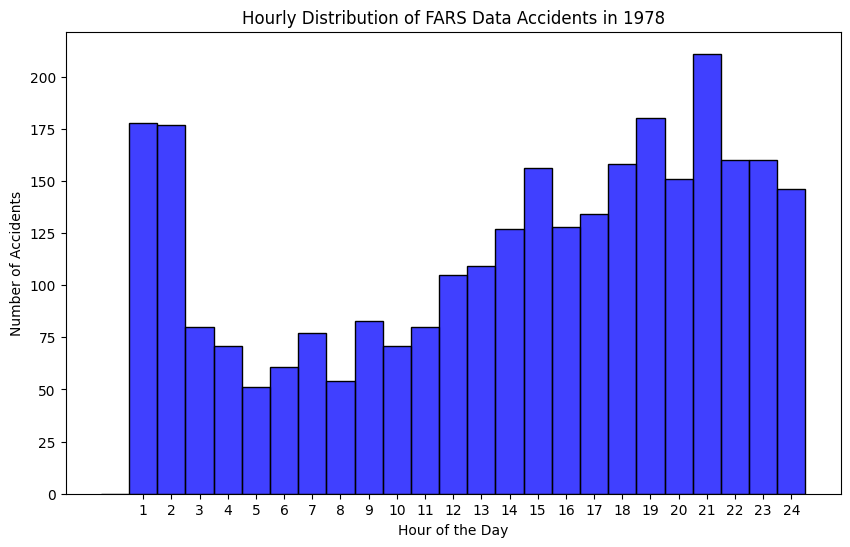

In [158]:
plt.figure(figsize=(10, 6))
bin_edges = [i - 0.5 for i in range(26)]  # Bins -0.5 to 24.5

sns.histplot(merged_data['1978']['HOUR'], bins=bin_edges, kde=False, color='blue')
plt.title('Hourly Distribution of FARS Data Accidents in 1978')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')

# Center x-ticks 
plt.xticks(range(1, 25))

plt.show()

In [152]:
np.unique(merged_data['2022']['HOUR'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

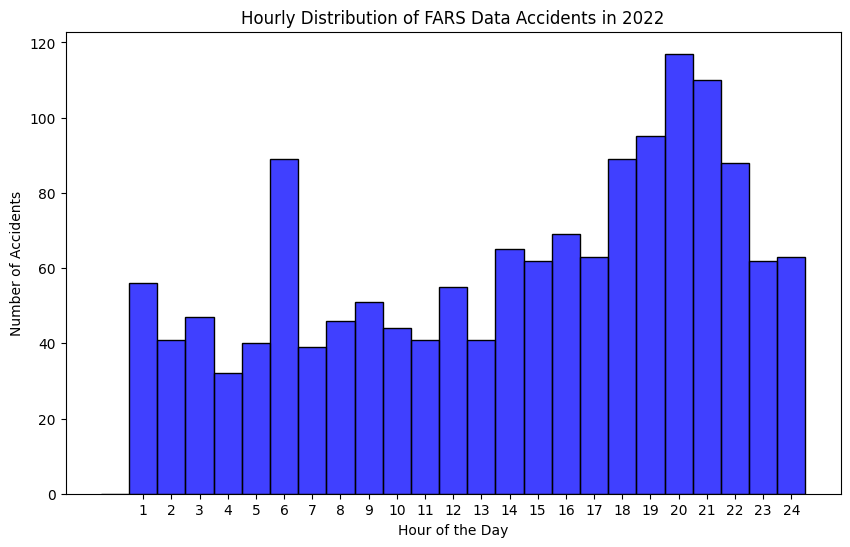

In [157]:
plt.figure(figsize=(10, 6))
bin_edges = [i - 0.5 for i in range(26)]  # Bins -0.5 to 24.5

sns.histplot(merged_data['2022']['HOUR'], bins=bin_edges, kde=False, color='blue')
plt.title('Hourly Distribution of FARS Data Accidents in 2022')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')

# Center x-ticks 
plt.xticks(range(1, 25))

plt.show()

In [127]:
merged_data['2022'].head()

,ST_CASE,STATENAME,NUM_PEDS,NUM_VEHC,PERSONS,COUNTYNAME,CITYNAME,MONTHNAME,DAYNAME,DAY_WEEKNAME,...,TYP_INTNAME,REL_ROADNAME,WRK_ZONENAME,LGT_CONDNAME,WEATHERNAME,SCH_BUS,HIT_RUN,MOD_YEAR,DEATHS,DR_DRINK
0,10001,Florida,0,2,2,VOLUSIA (127),NOT APPLICABLE,August,13,Saturday,...,Not an Intersection,On Roadway,NaN,Dark - Not Lighted,Clear,0,0,2016.0,1,0
1,10001,Florida,0,2,2,VOLUSIA (127),NOT APPLICABLE,August,13,Saturday,...,Not an Intersection,On Roadway,NaN,Dark - Not Lighted,Clear,0,0,2021.0,0,0
2,10002,Florida,0,1,1,SUMTER (119),NOT APPLICABLE,August,9,Tuesday,...,Not an Intersection,On Median,NaN,Dawn,Clear,0,0,2019.0,1,1
3,10002,Florida,0,1,1,SUMTER (119),NOT APPLICABLE,August,9,Tuesday,...,Not an Intersection,On Median,NaN,Dawn,Clear,0,0,2012.0,1,0
4,10003,Florida,0,2,5,LEE (71),NOT APPLICABLE,August,17,Wednesday,...,T-Intersection,On Roadway,NaN,Daylight,Clear,0,0,2006.0,1,0


In [141]:
merged_data['2022'].columns

Index(['ST_CASE', 'STATENAME', 'NUM_PEDS', 'NUM_VEHC', 'PERSONS', 'COUNTYNAME',
       'CITYNAME', 'MONTHNAME', 'DAYNAME', 'DAY_WEEKNAME', 'HOUR', 'ROAD_NAME',
       'ROUTENAME', 'RUR_URBNAME', 'FUNC_SYSNAME', 'RD_OWNERNAME',
       'MILE_MARKER', 'LATITUDE', 'LONGITUD', 'HARM_EVNAME', 'COLLISION_TYPE',
       'TYP_INTNAME', 'REL_ROADNAME', 'WRK_ZONENAME', 'LGT_CONDNAME',
       'WEATHERNAME', 'SCH_BUS', 'HIT_RUN', 'MOD_YEAR', 'DEATHS', 'DR_DRINK'],
      dtype='object')

In [146]:
np.unique(merged_data['2022']['CITYNAME'])

array(['ALTAMONTE SPRINGS', 'ALTHA', 'APPLE VALLEY', 'ARCADIA',
       'ARDEN HILLS', 'ARLINGTON', 'BALM', 'BARTOW', 'BELLE GLADE',
       'BLAINE', 'BOCA RATON', 'BONITA SPRINGS', 'BOYNTON BEACH',
       'BRANDON', 'BROOKLYN CENTER', 'BROOKLYN PARK', 'BROOKSVILLE',
       'BUNNELL', 'BURNSVILLE', 'CALLAWAY', 'CAMBRIDGE', 'CAPE CORAL',
       'CASS LAKE', 'CASSELBERRY', 'CHIEFLAND', 'CLEARWATER', 'COCOA',
       'COCONUT CREEK', 'COOPER CITY', 'CORAL SPRINGS', 'COTTAGE GROVE',
       'DANIA BEACH', 'DAVIE', 'DAYTONA BEACH', 'DAYTONA BEACH SHORES',
       'DEERFIELD BEACH', 'DELAND', 'DELRAY BEACH', 'DELTONA', 'DORAL',
       'EDGEWATER', 'ENSLEY', 'FLAGLER BEACH', 'FLORAL CITY',
       'FLORIDA CITY', 'FORT LAUDERDALE', 'FORT MYERS', 'FORT PIERCE',
       'FORT WALTON BEACH', 'FRUITLAND PARK', 'GAINESVILLE',
       'GOLDEN VALLEY', 'GROVELAND', 'HAMMONDVILLE', 'HIALEAH',
       'HIALEAH GARDENS', 'HOLLYWOOD', 'HOMESTEAD', 'IMMOKALEE',
       'INDIAN HARBOUR BEACH', 'INDIANTOWN', 'INVER

In [148]:
# Get rid of unknown values
conditions_to_remove = ['Reported as Unknown']
filtered_data = merged_data['2022'][~merged_data['2022']['COLLISION_TYPE'].isin(conditions_to_remove)]

merged_data['2022'] = filtered_data

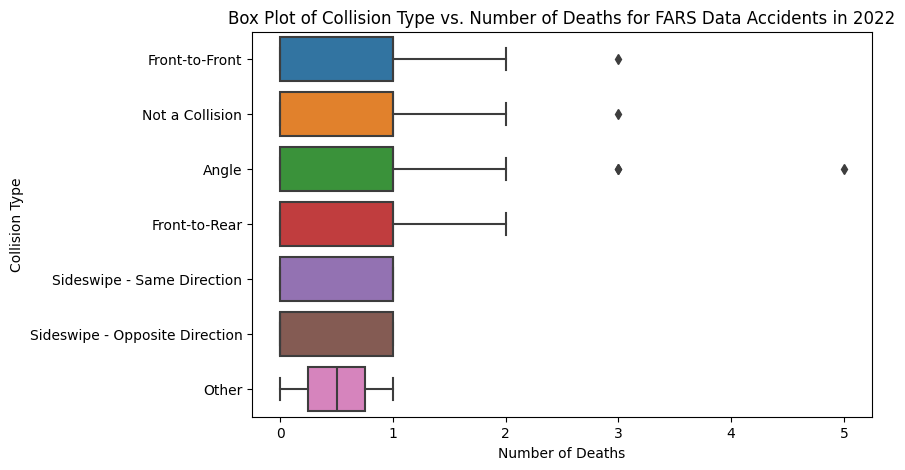

In [159]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='DEATHS', y='COLLISION_TYPE', data=merged_data['2022'])
plt.title('Box Plot of Collision Type vs. Number of Deaths for FARS Data Accidents in 2022')
plt.xlabel('Number of Deaths')
plt.ylabel('Collision Type')
plt.show()


In [134]:
# Drop unknown values
conditions_to_remove = ['Reported as Unknown', 'Dark - Unknown Lighting']
filtered_data = merged_data['2022'][~merged_data['2022']['LGT_CONDNAME'].isin(conditions_to_remove)]

merged_data['2022'] = filtered_data

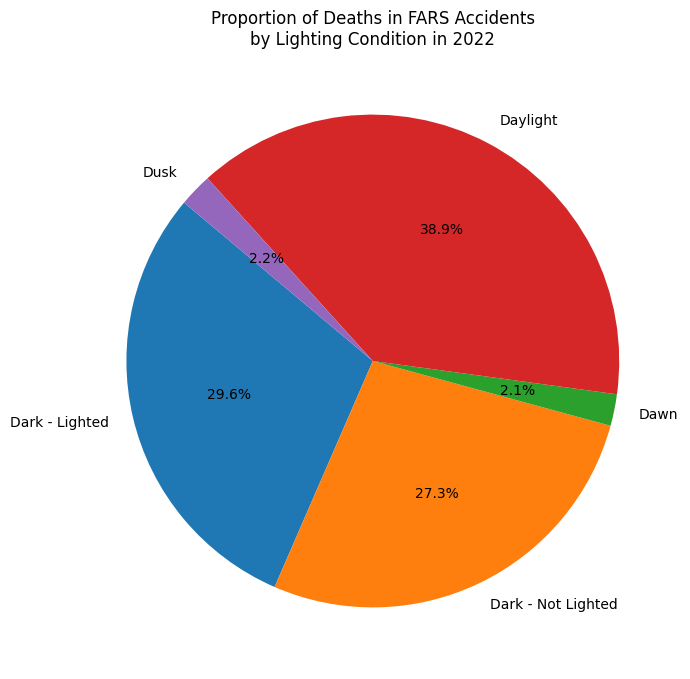

In [136]:
fatality_sums = merged_data['2022'].groupby('LGT_CONDNAME')['DEATHS'].sum()

plt.figure(figsize=(8, 8))
plt.pie(fatality_sums, labels=fatality_sums.index, autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Deaths in FARS Accidents\nby Lighting Condition in 2022')
plt.show()

#### Exporting data to CSV files to model in a separate notebook:

In [112]:
# Concatenate all years into 1 df & add a 'Year' column:
comb_df_sect_1 = pd.concat([df.assign(YEAR=name) for name, df in merged_data_section_1.items()], ignore_index=True)

# Puts YEAR column as first column of df:
comb_df_sect_1 = comb_df_sect_1[['YEAR'] + [col for col in comb_df_sect_1.columns if col != 'YEAR']]

# Write the combined df to a CSV file:
comb_df_sect_1.to_csv('acc_vehc_sect_1.csv', index=False)


In [113]:
comb_df_sect_2 = pd.concat([df.assign(YEAR=name) for name, df in merged_data_section_2.items()], ignore_index=True)

comb_df_sect_2 = comb_df_sect_2[['YEAR'] + [col for col in comb_df_sect_2.columns if col != 'YEAR']]

comb_df_sect_2.to_csv('acc_vehc_sect_2.csv', index=False)

In [114]:
comb_df_sect_3 = pd.concat([df.assign(YEAR=name) for name, df in merged_data_section_3.items()], ignore_index=True)

comb_df_sect_3 = comb_df_sect_3[['YEAR'] + [col for col in comb_df_sect_3.columns if col != 'YEAR']]

comb_df_sect_3.to_csv('acc_vehc_sect_3.csv', index=False)

In [115]:
comb_df_sect_4 = pd.concat([df.assign(YEAR=name) for name, df in merged_data_section_4.items()], ignore_index=True)

comb_df_sect_4 = comb_df_sect_4[['YEAR'] + [col for col in comb_df_sect_4.columns if col != 'YEAR']]

comb_df_sect_4.to_csv('acc_vehc_sect_4.csv', index=False)

In [116]:
comb_df_sect_5 = pd.concat([df.assign(YEAR=name) for name, df in merged_data_section_5.items()], ignore_index=False)

comb_df_sect_5 = comb_df_sect_5[['YEAR'] + [col for col in comb_df_sect_5.columns if col != 'YEAR']]

comb_df_sect_5.to_csv('acc_vehc_sect_5.csv', index=False)

In [117]:
comb_df_sect_6 = pd.concat([df.assign(YEAR=name) for name, df in merged_data_section_6.items()], ignore_index=False)

comb_df_sect_6 = comb_df_sect_6[['YEAR'] + [col for col in comb_df_sect_6.columns if col != 'YEAR']]

comb_df_sect_6.to_csv('acc_vehc_sect_6.csv', index=False)